## Preface

**Content based recommendation** is based on similarity among users/items obtained through their **attributes**. It uses the additional information(meta data) about the **users** or **items** i.e. it relies on what kind of **content** is already available. This meta data could be **user's demograpic information** like *age*, *gender*, *job*, *location*, *skillsets* etc. Similarly for **items** it can be *item name*, *specifications*, *category*, *registration date* etc.

So the core idea is to recommend items by finding similar items/users to the concerned **item/user** based on their **attributes**. 

In this kernel, I am going to discuss about **Content based recommendation** using **News category** dataset. The goal is to recommend **news articles** which are similar to the already read article by using attributes like article *headline*, *category*, *author* and *publishing date*.

So let's get started without any further delay.

## 1. Importing necessary Libraries

In [1]:
import numpy as np
import pandas as pd

import os
import math
import time
import random

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.figure_factory as ff
import plotly.graph_objects as go
import plotly.express as px

#for storing the model
import pickle

# Below libraries are for text processing using NLTK
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Below libraries are for feature representation using sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Below libraries are for similarity matrices using sklearn
from sklearn.metrics.pairwise import cosine_similarity  
from sklearn.metrics import pairwise_distances

from sklearn.metrics.pairwise import cosine_similarity


## 2. Loading Data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#news_articles = pd.read_json("/content/News_Category_Dataset_v2.json", lines = True)
#news_articles = pd.read_json("/content/drive/MyDrive/IR Project - Group 49/Dataset/News_Category_Dataset_v2.json", lines = True)
news_articles = pd.read_json("/content/drive/MyDrive/News_Category_Dataset_v2.json", lines = True)

In [4]:
news_articles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200853 entries, 0 to 200852
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   category           200853 non-null  object        
 1   headline           200853 non-null  object        
 2   authors            200853 non-null  object        
 3   link               200853 non-null  object        
 4   short_description  200853 non-null  object        
 5   date               200853 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(5)
memory usage: 9.2+ MB


The dataset contains about two million records of six different features. 

In [5]:
news_articles.category.unique().shape

(41,)

There are 41 unique categores in the data

In [6]:
news_articles.head()

,category,headline,authors,link,short_description,date
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018-05-26
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,2018-05-26
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,Ron Dicker,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...,2018-05-26
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,Ron Dicker,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ...",2018-05-26


## 3. Data Preprocessing

### 3.a Fetching only the articles from 2018  

Since the dataset size is quite large so processing through entire dataset may consume too much time. To refrain from this, we are only considering the latest articles from the year 2018. 

In [7]:
news_articles = news_articles[news_articles['date'] >= pd.Timestamp(2018,1,1)]

In [8]:
news_articles.shape

(8583, 6)

Now, the number of news articles comes down to 8583.

### 3.b Removing all the short headline articles 

After stop words removal from headline, the articles with very short headline may become blank headline articles. So let's remove all the articles with less words(<5) in the headline.   

In [9]:
news_articles = news_articles[news_articles['headline'].apply(lambda x: len(x.split())>5)]
print("Total number of articles after removal of headlines with short title:", news_articles.shape[0])

Total number of articles after removal of headlines with short title: 8530


### 3.c Checking and removing all the duplicates

Since some articles are exactly same in headlines, so let's remove all such articles having duplicate headline appearance.

In [10]:
news_articles.sort_values('headline',inplace=True, ascending=False)
duplicated_articles_series = news_articles.duplicated('headline', keep = False)
news_articles = news_articles[~duplicated_articles_series]
print("Total number of articles after removing duplicates:", news_articles.shape[0])

Total number of articles after removing duplicates: 8485


### 3.d Checking for missing values

In [11]:
news_articles.isna().sum()

category             0
headline             0
authors              0
link                 0
short_description    0
date                 0
dtype: int64

## 4. Basic Data Exploration 

### 4.a Basic statistics - Number of articles,authors,categories

In [12]:
print("Total number of articles : ", news_articles.shape[0])
print("Total number of authors : ", news_articles["authors"].nunique())
print("Total number of unqiue categories : ", news_articles["category"].nunique())

Total number of articles :  8485
Total number of authors :  892
Total number of unqiue categories :  26


### 4.b Distribution of articles category-wise

In [13]:
fig = go.Figure([go.Bar(x=news_articles["category"].value_counts().index, y=news_articles["category"].value_counts().values)])
fig['layout'].update(title={"text" : 'Distribution of articles category-wise','y':0.9,'x':0.5,'xanchor': 'center','yanchor': 'top'}, xaxis_title="Category name",yaxis_title="Number of articles")
fig.update_layout(width=800,height=700)
fig

From the bar chart, we can observe that **politics** category has **highest** number of articles then **entertainment** and so on.  

### 4.c Number of articles per month

Let's first group the data on monthly basis using **resample()** function. 

In [14]:
news_articles_per_month = news_articles.resample('m',on = 'date')['headline'].count()
news_articles_per_month

date
2018-01-31    2065
2018-02-28    1694
2018-03-31    1778
2018-04-30    1580
2018-05-31    1368
Freq: M, Name: headline, dtype: int64

In [15]:
fig = go.Figure([go.Bar(x=news_articles_per_month.index.strftime("%b"), y=news_articles_per_month)])
fig['layout'].update(title={"text" : 'Distribution of articles month-wise','y':0.9,'x':0.5,'xanchor': 'center','yanchor': 'top'}, xaxis_title="Month",yaxis_title="Number of articles")
fig.update_layout(width=500,height=500)
fig

From the bar chart, we can observe that **January** month has **highest** number of articles then **March** and so on.  

### 4.d PDF for the length of headlines 

In [16]:
fig = ff.create_distplot([news_articles['headline'].str.len()], ["ht"],show_hist=False,show_rug=False)
fig['layout'].update(title={'text':'PDF','y':0.9,'x':0.5,'xanchor': 'center','yanchor': 'top'}, xaxis_title="Length of a headline",yaxis_title="probability")
fig.update_layout(showlegend = False,width=500,height=500)
fig

The probability distribution function of headline length is almost similar to a **Guassian distribution**, where most of the headlines are 58 to 80 words long in length. 

By Data processing in Step 2, we get a subset of original dataset which has different index labels so let's make the indices uniform ranging from 0 to total number of articles. 

In [17]:
news_articles.index = range(news_articles.shape[0])

In [18]:
# Adding a new column containing both day of the week and month, it will be required later while recommending based on day of the week and month
news_articles["day and month"] = news_articles["date"].dt.strftime("%a") + "_" + news_articles["date"].dt.strftime("%b")

Since after text preprocessing the original headlines will be modified and it doesn't make sense to recommend articles by displaying modified headlines so let's copy the dataset into some other dataset and perform text preprocessing on the later.

In [19]:
news_articles_temp = news_articles.copy()

## 5. Text Preprocessing

### 5.a Stopwords removal

Stop words are not much helpful in analyis and also their inclusion consumes much time during processing so let's remove these. 

In [20]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [21]:
for i in range(len(news_articles_temp["headline"])):
    string = ""
    for word in news_articles_temp["headline"][i].split():
        word = ("".join(e for e in word if e.isalnum()))
        word = word.lower()
        if not word in stop_words:
          string += word + " "  
    if(i%1000==0):
      print(i)           # To track number of records processed
    news_articles_temp.at[i,"headline"] = string.strip()

0
1000
2000
3000
4000
5000
6000
7000
8000


### 5.b Lemmatization

Let's find the base form(lemma) of words to consider different inflections of a word same as lemma.

In [22]:
lemmatizer = WordNetLemmatizer()
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [23]:
for i in range(len(news_articles_temp["headline"])):
    string = ""
    for w in word_tokenize(news_articles_temp["headline"][i]):
        string += lemmatizer.lemmatize(w,pos = "v") + " "
    news_articles_temp.at[i, "headline"] = string.strip()
    if(i%1000==0):
        print(i)           # To track number of records processed

0
1000
2000
3000
4000
5000
6000
7000
8000


## BOW model

In [24]:
headline_vectorizer = CountVectorizer()
headline_features   = headline_vectorizer.fit_transform(news_articles_temp['headline'])

#### Saving the model

In [25]:
# save the model to disk
filename = 'Count-Vectorizer features.sav'
pickle.dump(headline_features, open(filename, 'wb'))

In [26]:
headline_features.get_shape()

(8485, 11122)

The output **BoW matrix**(headline_features) is a sparse matrix.

In [27]:
pd.set_option('display.max_colwidth', -1)  # To display a very long headline completely

<ipython-input-27-bc6d054540ec>:1: FutureWarning:

Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.



In [28]:
def bag_of_words_based_model(row_index, num_similar_items):
    couple_dist = pairwise_distances(headline_features,headline_features[row_index])
    indices = np.argsort(couple_dist.ravel())[0:num_similar_items]
    df = pd.DataFrame({'publish_date': news_articles['date'][indices].values,
               'headline':news_articles['headline'][indices].values,
                'Euclidean similarity with the queried article': couple_dist[indices].ravel(),'Category':news_articles['category'][indices].values})
    print("="*30,"Queried article details","="*30)
    print('headline : ',news_articles['headline'][indices[0]])
    print("\n","="*25,"Recommended articles : ","="*23)
    #return df.iloc[1:,1]
    return df.iloc[1:,], indices

article_list_bow_1, indices_bow_1=bag_of_words_based_model(133, 11) # Change the row index for any other queried article
article_list_bow_1

============================== Queried article details ==============================
headline :  Woman Fired After Flipping Off Trump's Motorcade Sues Former Employer

 ========================= Recommended articles :  =======================


,publish_date,headline,Euclidean similarity with the queried article,Category
1,2018-04-02,The Trump Administration Is Suing California Again,2.828427,POLITICS
2,2018-05-01,Texas Sues Trump Administration To End DACA,3.162278,POLITICS
3,2018-03-07,Stormy Daniels Suing Trump Over Nondisclosure Agreement,3.162278,POLITICS
4,2018-04-28,Trump: Mueller Should Never Have Been Appointed,3.162278,POLITICS
5,2018-04-24,Spanish Woman Looks More Like Trump Than The Donald Himself,3.162278,WEIRD NEWS
6,2018-02-12,What You Should Know About Trump's Nihilist Budget,3.162278,POLITICS
7,2018-05-09,The Caliphate Of Trump And A Planet In Ruins,3.162278,POLITICS
8,2018-03-26,Trump Ally Sues Qatar For Hacking His Email,3.162278,POLITICS
9,2018-02-21,All They Will Call You Will Be Deportees,3.162278,LATINO VOICES
10,2018-04-11,Pursuing Desegregation In The Trump Era,3.162278,POLITICS


In [29]:
article_list_bow_2, indices_bow_2=bag_of_words_based_model(143, 11)
article_list_bow_2

============================== Queried article details ==============================
headline :  Woman Allegedly Blows Up Pee Sample In A 7-Eleven Microwave

 ========================= Recommended articles :  =======================


,publish_date,headline,Euclidean similarity with the queried article,Category
1,2018-05-21,Airline Passenger Arrested After Allegedly Harassing Woman And Peeing On Seat,3.000000,WEIRD NEWS
2,2018-02-21,All They Will Call You Will Be Deportees,3.000000,LATINO VOICES
3,2018-01-25,Where The Work-For-Welfare Movement Is Heading,3.162278,POLITICS
4,2018-04-27,Pets Are 'The 1 Percent' Of Animals,3.162278,WEIRD NEWS
5,2018-01-19,How We Arrived At A 'Shithole' Shutdown,3.162278,POLITICS
6,2018-01-29,Here Are All The 2018 Grammy Winners,3.162278,ENTERTAINMENT
7,2018-02-01,"The Next Financial Crisis -- Not If, But When",3.162278,POLITICS
8,2018-01-11,Governor Accused Of Blackmail Allegedly Slapped Woman He Had Affair With,3.162278,POLITICS
9,2018-05-01,Pizza Rat Has Returned. Or Has He?,3.162278,WEIRD NEWS
10,2018-01-23,The 2018 Oscar Nominations Are Here,3.162278,ENTERTAINMENT


### 6.b Using TF -IDF method

In [30]:
tfidf_headline_vectorizer = TfidfVectorizer(min_df = 0)
tfidf_headline_features = tfidf_headline_vectorizer.fit_transform(news_articles_temp['headline'])

#### Saving the model

In [31]:
# save the model to disk
filename = 'tf-idf_vectorizer features.sav'
pickle.dump(tfidf_headline_features, open(filename, 'wb'))

In [32]:
news_articles

,category,headline,authors,link,short_description,date,day and month
0,QUEER VOICES,‘Will & Grace’ Creator To Donate Gay Bunny Book To Every Grade School In Indiana,Elyse Wanshel,https://www.huffingtonpost.com/entry/will-grace-creator-donate-john-olivers-gay-bunny-book-to-every-elementary-school-in-indiana_us_5ac28265e4b00fa46f854225,It's about to be a lot easier for kids in Mike Pence's home state to read “A Day in the Life of Marlon Bundo.”,2018-04-02,Mon_Apr
1,QUEER VOICES,‘The Voice’ Blind Auditions Make History With First Trans Contestant,"Lyndsey Parker, Yahoo Entertainment",https://www.huffingtonpost.com/entry/the-voice-blind-auditions-make-history-with-first-trans-contestant_us_5a9ece6ee4b002df2c5e39c2,"Austin Giorgio, 21: “How Sweet It Is (To Be Loved by You)” Young crooners have appeared on singing competitions since “American",2018-03-06,Tue_Mar
2,QUEER VOICES,‘The Penumbra’ Is The Queer Audio Drama You Didn’t Know You Needed,"Sarah Emily Baum, ContributorFreelance Writer",https://www.huffingtonpost.com/entry/the-penumbra-is-the-queer-audio-drama-you-didnt_us_5a48f900e4b0df0de8b06b29,"Young, fun, fantastical and, most notably, inclusive, the show is a must-listen for young queer people.",2018-01-05,Fri_Jan
3,COMEDY,‘The Opposition’ Gives Trump A Hot Lawyer Of His Own,Ed Mazza,https://www.huffingtonpost.com/entry/trump-hot-lawyer_us_5af5381ee4b0e57cd9f7fe84,"He's here to make a ""strong case"" for the president.",2018-05-11,Fri_May
4,ENTERTAINMENT,‘Stranger Things’ Fans Will Be Able To Visit The Upside Down IRL,Elyse Wanshel,https://www.huffingtonpost.com/entry/stranger-things-fans-will-be-able-to-visit-the-upside-down-irl_us_5ac3e3a6e4b063ce2e56c26a,"Hawkins is headed to Hollywood, Orlando and Singapore this fall.",2018-04-03,Tue_Apr
...,...,...,...,...,...,...,...
8480,BLACK VOICES,#JanetJacksonAppreciationDay Takes Over Twitter Ahead Of Super Bowl,Hayley Miller,https://www.huffingtonpost.com/entry/janet-jackson-twitter-super-bowl_us_5a774f4ce4b01ce33eb3f3f6,"""A Queen. An Icon. Black History. Black Present. Black Future.""",2018-02-04,Sun_Feb
8481,BLACK VOICES,#InWakanda Hashtag Brings The Blackest Of Nations To Life,Princess-India Alexander,https://www.huffingtonpost.com/entry/inwakanda-hashtag-black-twitter_us_5a821662e4b0892a035202e5,""" #InWakanda ashiness does not exist! There is jojoba oil in the wind.""",2018-02-13,Tue_Feb
8482,COMEDY,#IfMomWroteCandyHearts Is The Sweet And Sassy Valentine's Day Hashtag We Needed,Jenna Amatulli,https://www.huffingtonpost.com/entry/ifmomwrotecandyhearts-valentines-day-twitter-hashtag_us_5a844132e4b0adbaf3d96903,"""Don't eat this candy heart. It has too much sugar and it's almost time for bed.""",2018-02-14,Wed_Feb
8483,ENTERTAINMENT,#BlackHogwarts Magically Takes Twitter By Storm,Mary Papenfuss,https://www.huffingtonpost.com/entry/blackhogwarts-takes-twitter_us_5a58041ce4b04df054f778db,Expecto something very different.,2018-01-12,Fri_Jan


In [34]:
def tfidf_based_model(row_index, num_similar_items):
    couple_dist = pairwise_distances(tfidf_headline_features,tfidf_headline_features[row_index])
    indices = np.argsort(couple_dist.ravel())[0:num_similar_items]
    df = pd.DataFrame({'publish_date': news_articles['date'][indices].values,
               'headline':news_articles['headline'][indices].values,
                'Euclidean similarity with the queried article': couple_dist[indices].ravel(),
                'Category':news_articles['category'][indices].values})
    print("="*30,"Queried article details","="*30)
    print('headline : ',news_articles['headline'][indices[0]])
    print("\n","="*25,"Recommended articles : ","="*23)
    
    #return df.iloc[1:,1]
    return df.iloc[1:,], indices
article_list_tfidf_1, indices_tfidf_1 = tfidf_based_model(133, 11)
article_list_tfidf_1

============================== Queried article details ==============================
headline :  Woman Fired After Flipping Off Trump's Motorcade Sues Former Employer

 ========================= Recommended articles :  =======================


,publish_date,headline,Euclidean similarity with the queried article,Category
1,2018-05-21,The Supreme Court Just Made It A Lot Harder For You To Sue Your Employer,1.164067,POLITICS
2,2018-04-02,The Trump Administration Is Suing California Again,1.253867,POLITICS
3,2018-04-10,"Lou Dobbs Flips Out On Live TV, Urges Trump To 'Fire The SOB' Robert Mueller",1.258810,MEDIA
4,2018-04-26,Cardi B's Former Manager Sues Her For $10 Million,1.268704,BLACK VOICES
5,2018-04-03,A Third Woman Is Suing To Break A Trump-Related Nondisclosure Agreement,1.274264,POLITICS
6,2018-02-24,Former RNC Chair Fires Back At Claim He Was Only Hired Because He Was Black,1.274847,POLITICS
7,2018-01-16,State Employer Side Payroll Taxes And Loser Liberalism,1.276696,POLITICS
8,2018-02-21,Democrats Flip Kentucky State House Seat Where Trump Won Overwhelmingly,1.282008,POLITICS
9,2018-01-09,Big Tax Game Hunting: Employer Side Payroll Taxes,1.285147,POLITICS
10,2018-02-28,Democrats Flip 2 More GOP-Held State House Seats,1.287403,POLITICS


In [35]:
article_list_2,indices_tfidf_2 = tfidf_based_model(143, 11)
article_list_2

============================== Queried article details ==============================
headline :  Woman Allegedly Blows Up Pee Sample In A 7-Eleven Microwave

 ========================= Recommended articles :  =======================


,publish_date,headline,Euclidean similarity with the queried article,Category
1,2018-05-21,Airline Passenger Arrested After Allegedly Harassing Woman And Peeing On Seat,1.173314,WEIRD NEWS
2,2018-01-24,Stephen Colbert Thinks He's Found Proof: 'There Is Definitely A Pee Pee Tape',1.253339,COMEDY
3,2018-01-11,Governor Accused Of Blackmail Allegedly Slapped Woman He Had Affair With,1.257262,POLITICS
4,2018-02-02,Sean Hannity's Pee Pee Tape Discussion Goes Completely Off The Rails,1.259004,MEDIA
5,2018-01-11,Immigration Agents Raid Nearly 100 7-Eleven Stores Nationwide In Show Of Force,1.288777,POLITICS
6,2018-05-03,You Can't Unsee Jim Carrey's Naked Trump 'Urine Sample' Artwork,1.290432,ENTERTAINMENT
7,2018-05-17,The Farm Bill Could Be A Huge Blow To Animals,1.301425,POLITICS
8,2018-03-09,'Stand Down': How The Obama Team Blew The Response To Russian Meddling,1.306652,POLITICS
9,2018-04-18,Trevor Noah Has A Mind Blowing Theory About Sean Hannity,1.307164,COMEDY
10,2018-03-29,Huge Debate Blows Up Over Which 'Friends' Character Would Have Voted For Trump,1.308664,ENTERTAINMENT


##**Diversity Measure**


**1. Calculating ILD scores for recommendations**

In [69]:
articles_bow_1 = news_articles.iloc[indices_bow_1]
articles_bow_2 = news_articles.iloc[indices_bow_2]
articles_tfidf_1 = news_articles.iloc[indices_tfidf_1]
articles_tfidf_2 = news_articles.iloc[indices_tfidf_2]

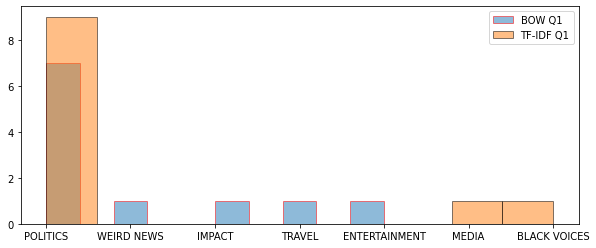

In [80]:
from sys import platlibdir
plt.figure().set_figwidth(10)
plt.hist(articles_bow_1.category, alpha=0.5, label='BOW Q1', edgecolor = 'red')

plt.hist(articles_tfidf_1.category, alpha=0.5, label='TF-IDF Q1', edgecolor = 'black')

plt.legend(loc='upper right')
plt.show()

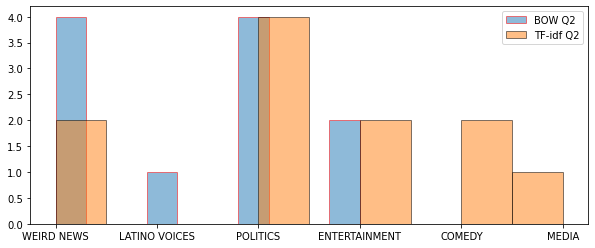

In [81]:
plt.figure().set_figwidth(10)
plt.hist(articles_bow_2.category, alpha=0.5, label='BOW Q2', edgecolor = 'red')
plt.hist(articles_tfidf_2.category, alpha=0.5, label='TF-idf Q2', edgecolor = 'black')
plt.legend(loc='upper right')
plt.show()

In [82]:
headline_vectorizer_bow_1 = CountVectorizer()
headline_features_bow_1   = headline_vectorizer_bow_1.fit_transform(articles_bow_1['category'])
headline_features_bow_1

<11x6 sparse matrix of type '<class 'numpy.int64'>'
	with 12 stored elements in Compressed Sparse Row format>

In [39]:
articles_bow_1['category']

133     POLITICS     
1588    POLITICS     
1842    POLITICS     
2051    POLITICS     
748     POLITICS     
2206    WEIRD NEWS   
308     POLITICS     
1775    POLITICS     
1142    POLITICS     
7681    LATINO VOICES
3019    POLITICS     
Name: category, dtype: object

In [83]:
headline_vectorizer_bow_2 = CountVectorizer()
headline_features_bow_2  = headline_vectorizer_bow_2.fit_transform(articles_bow_2['category'])
headline_features_bow_2

<11x6 sparse matrix of type '<class 'numpy.int64'>'
	with 16 stored elements in Compressed Sparse Row format>

In [84]:
articles_bow_2['category']

143     WEIRD NEWS   
7727    WEIRD NEWS   
7681    LATINO VOICES
301     POLITICS     
3181    WEIRD NEWS   
5253    POLITICS     
5488    ENTERTAINMENT
1665    POLITICS     
5587    POLITICS     
3151    WEIRD NEWS   
1812    ENTERTAINMENT
Name: category, dtype: object

In [85]:
headline_vectorizer_tfidf_1 = TfidfVectorizer(min_df = 0)
headline_features_tfidf_1   = headline_vectorizer_tfidf_1.fit_transform(articles_tfidf_1['category'])
headline_features_tfidf_1

<11x4 sparse matrix of type '<class 'numpy.float64'>'
	with 12 stored elements in Compressed Sparse Row format>

In [43]:
articles_tfidf_1['category']

133     POLITICS    
1600    POLITICS    
1588    POLITICS    
4238    MEDIA       
7056    BLACK VOICES
7839    POLITICS    
5875    POLITICS    
2173    POLITICS    
6576    POLITICS    
7317    POLITICS    
6577    POLITICS    
Name: category, dtype: object

In [86]:
headline_vectorizer_tfidf_2 = TfidfVectorizer(min_df = 0)
headline_features_tfidf_2  = headline_vectorizer_tfidf_2.fit_transform(articles_tfidf_2['category'])
headline_features_tfidf_2

<11x6 sparse matrix of type '<class 'numpy.float64'>'
	with 13 stored elements in Compressed Sparse Row format>

In [45]:
articles_tfidf_2['category']

143     WEIRD NEWS   
7727    WEIRD NEWS   
2117    COMEDY       
5587    POLITICS     
2503    MEDIA        
5175    POLITICS     
82      ENTERTAINMENT
1747    POLITICS     
8211    POLITICS     
1236    COMEDY       
5238    ENTERTAINMENT
Name: category, dtype: object

In [130]:
vectors_bow_1 =pd.DataFrame(headline_features_bow_1.toarray())
cosine_similarities_bow_1 = cosine_similarity(vectors_bow_1, vectors_bow_1)


#calculatig average of all rows in the cosine similarity matrix
row_avg = []
for ind in range(len(cosine_similarities_bow_1)):
  avg = sum(cosine_similarities_bow_1[ind])/cosine_similarities_bow_1[ind].shape[0]
  row_avg.append(avg)

ILD_bow_1 = 1-(sum(row_avg)/len(row_avg))
ILD_bow_1

0.43801652892561976

In [129]:
vectors_bow_2 =pd.DataFrame(headline_features_bow_2.toarray())
cosine_similarities_bow_2 = cosine_similarity(vectors_bow_2, vectors_bow_2)


#calculatig average of all rows in the cosine similarity matrix
row_avg = []
for ind in range(len(cosine_similarities_bow_2)):
  avg = sum(cosine_similarities_bow_2[ind])/cosine_similarities_bow_2[ind].shape[0]
  row_avg.append(avg)

ILD_bow_2 = 1-(sum(row_avg)/len(row_avg))
ILD_bow_2

0.30578512396694213

In [89]:
vectors_tfidf_1 =pd.DataFrame(headline_features_tfidf_1.toarray())
cosine_similarities_tfidf_1 = cosine_similarity(vectors_tfidf_1, vectors_tfidf_1)


#calculating average of all rows in the cosine similarity matrix
row_avg = []
for ind in range(len(cosine_similarities_tfidf_1)):
  avg = sum(cosine_similarities_tfidf_1[ind])/cosine_similarities_tfidf_1[ind].shape[0]
  row_avg.append(avg)

ILD_tfidf_1 = 1-(sum(row_avg)/len(row_avg))
ILD_tfidf_1

0.31404958677685946

In [128]:
vectors_tfidf_2 =pd.DataFrame(headline_features_tfidf_2.toarray())
cosine_similarities_tfidf_2 = cosine_similarity(vectors_tfidf_2, vectors_tfidf_2)


#calculating average of all rows in the cosine similarity matrix
row_avg = []
for ind in range(len(cosine_similarities_tfidf_2)):
  avg = sum(cosine_similarities_tfidf_2[ind])/cosine_similarities_tfidf_2[ind].shape[0]
  row_avg.append(avg)

ILD_tfidf_2 = 1-(sum(row_avg)/len(row_avg))
ILD_tfidf_2

0.23966942148760328

In [91]:

vectors =pd.DataFrame(tfidf_headline_features.toarray())
# vectors

In [101]:
!pip install beautifultable

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Introducing diversity into the topics 

In [120]:
# random_values = []
# while(len(random_values)<3):
random_values=random.sample(range(0, 1000), 8)
random_values

[726, 451, 608, 850, 196, 556, 382, 61]

In [121]:
indices_bow_1_diverse = indices_bow_1

for i in range(3,11):
  indices_bow_1_diverse[i] = random_values[i-8]

indices_bow_1_diverse

array([ 133, 1588, 1842,  850,  196,  556,  382,   61,  726,  451,  608])

In [122]:
articles_bow_1_diverse = news_articles.iloc[indices_bow_1_diverse]

(array([5., 0., 1., 0., 2., 0., 1., 0., 1., 1.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <BarContainer object of 10 artists>)

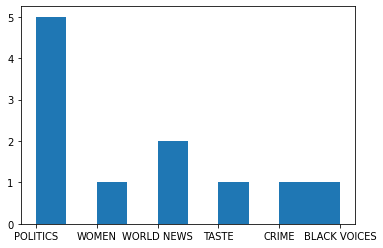

In [123]:
plt.hist(articles_bow_1_diverse.category)

In [124]:
headline_vectorizer_bow_1_diverse = CountVectorizer()
headline_features_bow_1_diverse   = headline_vectorizer_bow_1_diverse.fit_transform(articles_bow_1_diverse['category'])
headline_features_bow_1_diverse

<11x8 sparse matrix of type '<class 'numpy.int64'>'
	with 14 stored elements in Compressed Sparse Row format>

In [125]:
vectors_bow_1_diverse =pd.DataFrame(headline_features_bow_1_diverse.toarray())
cosine_similarities_bow_1_diverse = cosine_similarity(vectors_bow_1_diverse, vectors_bow_1_diverse)


#calculatig average of all rows in the cosine similarity matrix
row_avg = []
for ind in range(len(cosine_similarities_bow_1_diverse)):
  avg = sum(cosine_similarities_bow_1_diverse[ind])/cosine_similarities_bow_1_diverse[ind].shape[0]
  row_avg.append(avg)

ILD_bow_1_diverse = 1-(sum(row_avg)/len(row_avg))
ILD_bow_1_diverse

0.7272727272727273

In [126]:
print("The ILD score after introducing random diversity in the recmmended articles:",ILD_bow_1_diverse)

The ILD score after introducing random diversity in the recmmended articles: 0.7272727272727273


In [131]:
from beautifultable import BeautifulTable
table = BeautifulTable()
table.rows.append([ILD_bow_1, ILD_bow_2, ILD_tfidf_1, ILD_tfidf_2, ILD_bow_1_diverse])
table.rows.header = ["Intra-List Similarity"]
table.columns.header = ["BOW Query 1", "BOW Query 2", "Tf-Idf Query 1", "Tf-Idf Query 2", "BOW with random function"]
print(table)

+---------------+---------+---------+-----------+-----------+------------------+
|               | BOW Que | BOW Que | Tf-Idf Qu | Tf-Idf Qu | BOW with random  |
|               |  ry 1   |  ry 2   |   ery 1   |   ery 2   |     function     |
+---------------+---------+---------+-----------+-----------+------------------+
| Intra-List Si |  0.438  |  0.306  |   0.314   |   0.24    |      0.727       |
|   milarity    |         |         |           |           |                  |
+---------------+---------+---------+-----------+-----------+------------------+


**2. Intra List Diversity (ILD)**

In [57]:
from sklearn.metrics.pairwise import linear_kernel

In [58]:
cosine_similarities = linear_kernel(vectors, vectors)

In [59]:
cosine_similarities

array([[1.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.13390773],
       [0.        , 1.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 1.        , ..., 0.08671627, 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.08671627, ..., 1.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.13390773, 0.        , 0.        , ..., 0.        , 0.        ,
        1.        ]])

In [60]:
#calculatig average of all rows in the cosine similarity matrix
row_avg = []
for ind in range(len(cosine_similarities)):
  avg = sum(cosine_similarities[ind])/cosine_similarities[ind].shape[0]
  row_avg.append(avg)

ILD = sum(row_avg)/len(row_avg)
ILD


0.0043452074701240346

### Diversity measure of list recommended by BOW

In [61]:


vectors_bow =pd.DataFrame(headline_features.toarray())

In [62]:
cosine_similarities_bow = linear_kernel(vectors_bow, vectors_bow)

In [63]:
#calculatig average of all rows in the cosine similarity matrix
row_avg = []
for ind in range(len(cosine_similarities_bow)):
  avg = sum(cosine_similarities_bow[ind])/cosine_similarities_bow[ind].shape[0]
  row_avg.append(avg)

ILD = sum(row_avg)/len(row_avg)
ILD


0.08542745716816685

**3. Individual Diversity (ID)**

In [64]:
#ID = ( 1/(n*(n-1)) ) * (sum of pairwise distances)

ID = sum(sum(cosine_similarities))/(len(cosine_similarities)*(len(cosine_similarities)-1))
ID


0.004345719635078083

In [65]:
sum(cosine_similarities)

array([28.76910675, 36.4818606 , 29.1708502 , ..., 18.18750957,
       25.1816208 , 41.55833352])

In [66]:
#ID = ( 1/(n*(n-1)) ) * (sum of pairwise distances)

ID = sum(sum(cosine_similarities))/(len(cosine_similarities)*(len(cosine_similarities)-1))
ID


0.004345719635078083

In [67]:
sum(cosine_similarities)

array([28.76910675, 36.4818606 , 29.1708502 , ..., 18.18750957,
       25.1816208 , 41.55833352])

In [103]:
#calculating fir the first 10 articles

# couple_dist_matrix=[]
# for index in range(10):
#   couple_dist_temp = pairwise_distances(vectorizer_features[:10],vectorizer_features[index])
#   couple_dist_matrix.append(couple_dist_temp)

# # print(couple_dist_matrix)
# couple_dist_matrix

